# Error analysis for string algorithm tasks

In [28]:
import re
import random
import string

import torch
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from arithmetic_lm.model import (
    TransformerDecoder,
    load_model,
    find_latest_ckpt,
    generate,
)
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.constants import PLOTS_DIR, CHECKPOINTS_DIR

import warnings

warnings.filterwarnings("ignore")

In [2]:
tokenizer = CharTokenizer()

In [5]:
ckpts = {
    # === strlen_v1 ===
    # "string_length": "../checkpoints/strlen_v1/trans_dec_1layers_192embd_2head",
    # === strindex_v1 ===
    "retrieval_by_index": "../checkpoints/strindex_v1/trans_dec_1layers_192embd_2head"
}

ckpts = {k: find_latest_ckpt(v) for k, v in ckpts.items()}

In [26]:
# load model
model, hpaarams = load_model(ckpts["retrieval_by_index"])
model.eval()

TransformerDecoder(
  (embedding): Embedding(100, 192)
  (pos_encoder): AbsolutePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
        )
        (linear1): Linear(in_features=192, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=768, out_features=192, bias=True)
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=192, out_features=100, bias=False)
)

In [6]:
# subdir = PLOTS_DIR / "exp17_strlen_v1"
subdir = PLOTS_DIR / "exp18_strindex_v1"
subdir.mkdir(exist_ok=True)

## Test accuracy by string length and index

Generate different random strings (not in the training set) of different lengths, and evaluate accuracy for different indexes. Plot results as a heatmap.

In [20]:
def get_set_from_file(filepath: str | Path) -> set[str]:
    with open(filepath, "r") as f:
        # get only string itself
        return set(map(lambda line: line[: line.index("[")], f.readlines()))

In [21]:
# training set
training_set = get_set_from_file(
    "../data/strindex_v1/2M/train_strindex_1-25chars_2M.txt"
)
print(repr(next(iter(training_set))))

'ega63z9esmwk8oh2tt'


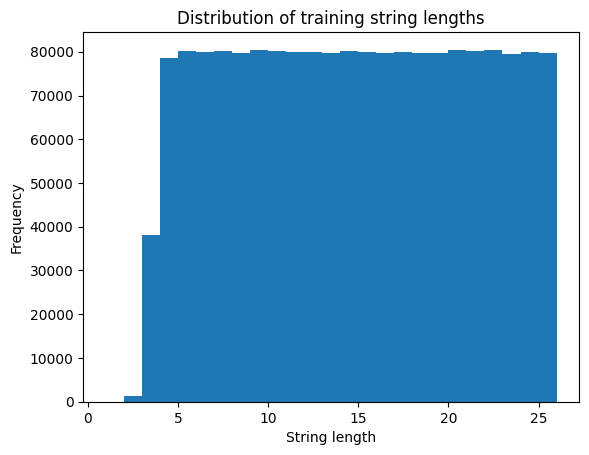

In [22]:
# plot distribution of training string lengths
training_set_lengths = [len(s) for s in training_set]
plt.hist(training_set_lengths, bins=range(1, max(training_set_lengths) + 2))
plt.title("Distribution of training string lengths")
plt.xlabel("String length")
plt.ylabel("Frequency")
plt.savefig(subdir / "training_set_lengths.png")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

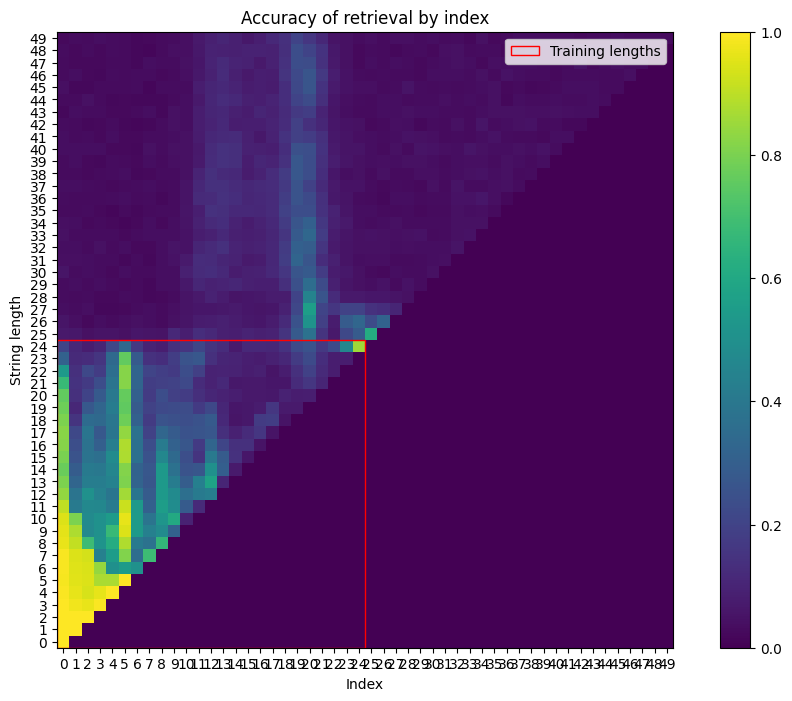

In [50]:
# generate test examples
max_test_len = 50
n_samples_per_len = 1000
n_correct = np.zeros((max_test_len, max_test_len), dtype=int)
CHARS = list(string.ascii_lowercase + string.digits)


for length in range(1, max_test_len + 1):
    print(length, end=" ")
    i = 0
    while i < n_samples_per_len:
        # generate random string
        s = "".join(random.choices(CHARS, k=length))
        if length > 3 and s in training_set:
            continue
        i += 1

        for index in range(0, length):
            # generate prompt
            prompt_str = f"${s}[{index}]="
            prompt = torch.tensor(tokenizer.encode(prompt_str)).unsqueeze(0)
            pred_ans = generate(
                model, prompt, max_new_tokens=2, stop_token=tokenizer.encode("$")[0]
            )
            pred_ans_str = tokenizer.decode(pred_ans[0])
            if pred_ans_str[0] == str(s[index]):
                n_correct[length - 1, index] += 1

# plot accuracy
plt.figure(figsize=(12, 8))
plt.imshow(n_correct / n_samples_per_len, cmap="viridis", interpolation="none")
plt.colorbar()

# flip y axis
plt.gca().invert_yaxis()

# draw a red rect around training area (lengths 1-25)
max_train_len = max(training_set_lengths)
plt.gca().add_patch(
    plt.Rectangle(
        (-0.5, -0.5), max_train_len, max_train_len, fill=False, edgecolor="red"
    )
)
plt.legend(["Training lengths"])

plt.title("Accuracy of retrieval by index")
plt.xlabel("Index")
plt.ylabel("String length")
plt.xticks(range(max_test_len))
plt.yticks(range(max_test_len))

plt.savefig(subdir / "accuracy.png")
plt.show()